##1. Importación de librerias

In [1]:
# Librería para manejar las contracciones que se presentan en el inglés.
!pip install contractions
# librería para manejar las flexiones gramaticales en el idioma inglés.
!pip install inflect
#libreria para convertir números
!pip install num2words
# Manejo de gráficas
!pip install scikit-plot
!pip install spacy
# Manejo de gráficas
!pip install scikit-plot

!pip install pandas==2.0.0

!pip install setuptools wheel

!pip install spacy
# Load the Spanish language model
!python -m spacy download es_core_news_sm
# librería Natural Language Toolkit, usada para trabajar con textos
import nltk
# Punkt permite separar un texto en frases.
nltk.download('punkt')
# Descarga todas las palabras vacias, es decir, aquellas que no aportan nada al significado del texto
# ¿Cuales son esas palabras vacías?

nltk.download('stopwords')
# Descarga de paquete WordNetLemmatizer, este es usado para encontrar el lema de cada palabra
# ¿Qué es el lema de una palabra? ¿Qué tan dificil puede ser obtenerlo, piensa en el caso en que tuvieras que escribir la función que realiza esta tarea?
nltk.download('wordnet')
# Instalación de librerias
import pandas as pd
import numpy as np
import sys
import spacy
import seaborn as sns
!{sys.executable} -m pip install pandas-profiling

import re, string, unicodedata
import contractions
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer, SnowballStemmer

from sklearn.model_selection import train_test_split,GridSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, ConfusionMatrixDisplay, accuracy_score, recall_score, f1_score, precision_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from collections import defaultdict
from scipy import stats as st
from sklearn import svm
from num2words import num2words

from sklearn.base import BaseEstimator, ClassifierMixin

import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 26.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


##2. Carga y lectura de datos

Inicialmente se realizó la carga de los datos, a nuestro grupo le correspondía el conjunto de datos tipo 1, los datos vienen con una estructura definida, son dos columnas. Review contiene la descripción realizada por el calificador y Class contiene el valor de la calificación brindada, esta calificación es un número entero entre 1 y 5.

In [2]:
data=pd.read_csv('/content/sample_data/tipo1_entrenamiento_estudiantes.csv', sep=',', encoding = 'utf-8')
data_t=data.copy()
data_t = data_t.reset_index(drop = True)
data_t.head()

,Review,Class
0,Nos alojamos en una casa alquilada en la ciuda...,4
1,"La comida está bien, pero nada especial. Yo te...",3
2,"En mi opinión, no es una como muchos usuarios ...",3
3,esta curiosa forma que asemeja una silla de mo...,4
4,Lo mejor era la limonada. Me gusto la comida d...,2


In [3]:
data_t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7875 entries, 0 to 7874
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  7875 non-null   object
 1   Class   7875 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 123.2+ KB


Podemos ver que la columna review es de tipo objeto, ya que es texto, mientras que la columna Class es de tipo número porque contiene la calificación. Por otro lado tenemos 7875 registros de los cuales 7875 contienen datos ya que ninguno es nulo.

##3. Funciones para utilizar dentro del cuaderno.

In [4]:
#Función para remover todas las puntuaciones de un conjunto de palabras
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        if word is not None:
            new_word = re.sub(r'[^\w\s]', '', word)
            if new_word != '':
                new_words.append(new_word)
    return new_words

# Función para remover las stop words del español de una conjunto de palabras
spanish_stopwords = set(stopwords.words('spanish'))
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word is not None:
            if word not in spanish_stopwords:
                new_words.append(word)
    return new_words

#Función para dejar todas las palabras recibidas sin mayusculas
def lowerCase(words):
    new_words = []
    for word in words:
        if word is not None:
                new_word = word.lower()
                new_words.append(new_word)
    return new_words

#Función para reemplazar numeros por la representación textual del número
def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

###3. Limpieza de los datos

Inicialmente realizamos la eliminacion de duplicados, con el fin de no generar inconsistencias a la hora de entrenar el modelo.

In [5]:
data_t.duplicated(keep = False).sum()

109

In [6]:
data_t.drop_duplicates(subset=['Review'], inplace=True)

In [7]:
data_t.duplicated(keep = False).sum()

0

3.1 Vamos a realizar la tokenizazción de la columna Review, esto va a quedar en una nueva columna llamada words que va a contener el resultado del procesamiento del texto

In [8]:
data_t['words'] = data_t['Review'].apply(word_tokenize)
data_t.head()

,Review,Class,words
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[Nos, alojamos, en, una, casa, alquilada, en, ..."
1,"La comida está bien, pero nada especial. Yo te...",3,"[La, comida, está, bien, ,, pero, nada, especi..."
2,"En mi opinión, no es una como muchos usuarios ...",3,"[En, mi, opinión, ,, no, es, una, como, muchos..."
3,esta curiosa forma que asemeja una silla de mo...,4,"[esta, curiosa, forma, que, asemeja, una, sill..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[Lo, mejor, era, la, limonada, ., Me, gusto, l..."


En la siguiente sección se van a aplicar los siguientes pasos para preparar el texto, primero se van a remover las puntuaciones, luego los stopwords, vamos a pasar todo a minúsculas y finalmente se reemplazan todos los numeros por su representación textual.

In [9]:
data_t['words'] = data_t['words'].apply(remove_punctuation)
data_t['words'] = data_t['words'].apply(remove_stopwords)
data_t['words'] = data_t['words'].apply(lowerCase)
data_t['words'] = data_t['words'].apply(replace_numbers)
data_t.head()

,Review,Class,words
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[nos, alojamos, casa, alquilada, ciudad, amura..."
1,"La comida está bien, pero nada especial. Yo te...",3,"[la, comida, bien, especial, yo, mejor, comida..."
2,"En mi opinión, no es una como muchos usuarios ...",3,"[en, opinión, usuarios, reclaman, es, gran, pa..."
3,esta curiosa forma que asemeja una silla de mo...,4,"[curiosa, forma, asemeja, silla, montar, ahi, ..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[lo, mejor, limonada, me, gusto, comida, mundo..."


En la siguiente sección realizamos una busqueda de todas las palabras de los datos en este punto, y armamos una lista de aquellas palabras que se utilizan mas de 20 veces. Esto con el objetivo de que el modelo logre basarse en palabras que de verdad tengan relevancia y puedan ser utiles para el modelo utilizado.

In [10]:
#Funcion para recorrer todas las palabras de una columna y encontrar su frecuencia
word_freq = defaultdict(int)

for word_list in data_t['words']:
    for word in word_list:
        word_freq[word] += 1

word_freq_list = [(word, freq) for word, freq in word_freq.items() if freq > 20]

word_freq_list.sort(key=lambda x: x[1], reverse=True)
def remove_not_valuable_words(words):
    new_words = []
    for word in words:
        if word is not None:
            if any(word == w[0] for w in word_freq_list):  # Check if the word exists in the list of words
                new_words.append(word)
    return new_words
print(word_freq_list[:5])
##SE remueven todas las palabras que aparecen menos de X veces
data_t['words'] = data_t['words'].apply(remove_not_valuable_words)
data_t.head()

[('hotel', 3788), ('el', 3228), ('la', 3121), ('lugar', 2327), ('comida', 2231)]


,Review,Class,words
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[nos, alojamos, casa, ciudad, amurallada, pare..."
1,"La comida está bien, pero nada especial. Yo te...",3,"[la, comida, bien, especial, yo, mejor, comida..."
2,"En mi opinión, no es una como muchos usuarios ...",3,"[en, opinión, es, gran, paladar, parece, ser, ..."
3,esta curiosa forma que asemeja una silla de mo...,4,"[forma, silla, ahi, nombre, ciudad, vale, pena..."
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[lo, mejor, me, gusto, comida, mundo, frío]"


En la siguiente sección vamos a contar cuantas palabras clave hay en cada descripción, esto con el fin de darle información adicional al modelo y bajar la complejidad a la hora de dar una predicción. Según el análisis vamos a utilizar las palabras clave que hayan sido utilizadas en mas de 1000 registrosya que pueden ser un patron interesante para que el modelo lo tenga en cuenta.

In [11]:
word_freq_key = [(word, freq) for word, freq in word_freq.items() if freq > 1000]

word_freq_key.sort(key=lambda x: x[1], reverse=True)
def count_words_above_threshold(words):
    count = 0
    for word in words:
        if word is not None:
            if any(word == w[0] for w in word_freq_list):  # Check if the word exists in the list of words
                count += 1
    return count
data_t['Palabras Clave'] = data_t['words'].apply(count_words_above_threshold)
data_t.head()

,Review,Class,words,Palabras Clave
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[nos, alojamos, casa, ciudad, amurallada, pare...",30
1,"La comida está bien, pero nada especial. Yo te...",3,"[la, comida, bien, especial, yo, mejor, comida...",22
2,"En mi opinión, no es una como muchos usuarios ...",3,"[en, opinión, es, gran, paladar, parece, ser, ...",42
3,esta curiosa forma que asemeja una silla de mo...,4,"[forma, silla, ahi, nombre, ciudad, vale, pena...",13
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[lo, mejor, me, gusto, comida, mundo, frío]",7


In [12]:
# Supongamos que 'df' es tu DataFrame y 'column_name' es el nombre de la columna en la que quieres contar los valores
count = sum(data_t['Palabras Clave'] == 0)
print("Número de filas con el valor 0 en la columna '{}': {}".format('Palabras Clave', count))

Número de filas con el valor 0 en la columna 'Palabras Clave': 0


###3.3 Normalización de los datos

Las siguientes son las implementaciones de lemmatize y stemmatize que nos ayudaran a dejar los datos con una complejidad mas baja para darselos al algoritmo.

In [13]:
nlp = spacy.load("es_core_news_sm")
def lemmatize_words(words):
    # Join the list of words into a single string
    text = ' '.join(words)
    # Process the text using the language model
    doc = nlp(text)
    # Lemmatize each token in the document
    lemmas = [token.lemma_ for token in doc]
    return lemmas
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    return [stemmer.stem(word) for word in words]

En esta sección se realiza primero una lemmatización de los datos y luego se aplica la funcion de stem, se realiza en este orden para que la función de lemmatización tenga las palabras reales y logra analizar un posible contexto para hacer los ajustes

In [14]:
data_t['words'] = data_t['words'].apply(lemmatize_words)
data_t['words'] = data_t['words'].apply(stem_words)
data_t.head()

,Review,Class,words,Palabras Clave
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[yo, alog, cas, ciud, amurall, parec, tant, se...",30
1,"La comida está bien, pero nada especial. Yo te...",3,"[el, com, bien, especial, yo, mejor, com, esta...",22
2,"En mi opinión, no es una como muchos usuarios ...",3,"[en, opinion, ser, gran, palad, parec, ser, pa...",42
3,esta curiosa forma que asemeja una silla de mo...,4,"[form, sill, ahi, nombr, ciud, val, pen, si, p...",13
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[el, mejor, yo, gust, com, mund, fri]",7


Ahora vamos a agregar algunas características que nos pueden ser útiles para darla la información al modelo, estas son número de palabras, número de caracteres, promedio de longitud de palabras, cantidad de palabras clave que fue agregada anteriormente.

In [15]:
#Funcion para encontrar el promedio de longitud de una palabra
def average_word_length(words):

    # Inicializar una variable para almacenar la suma de las longitudes de las palabras
    total_length = 0

    # Calcular la longitud de cada palabra y sumarla a total_length
    for word in words:
        total_length += len(word)

    # Calcular el promedio dividiendo la suma de las longitudes entre el número total de palabras
    if len(words) > 0:
        avg_length = total_length / len(words)
    else:
        avg_length = 0

    return avg_length
data_t['PromedioLongitud'] = data_t['words'].apply(average_word_length)
data_t['Conteo'] = [len(x) for x in data_t['words']]
data_t['Caracteres'] =[len(x.split()) for x in data_t['Review']]
data_t.head()

,Review,Class,words,Palabras Clave,PromedioLongitud,Conteo,Caracteres
0,Nos alojamos en una casa alquilada en la ciuda...,4,"[yo, alog, cas, ciud, amurall, parec, tant, se...",30,4.433333,30,72
1,"La comida está bien, pero nada especial. Yo te...",3,"[el, com, bien, especial, yo, mejor, com, esta...",22,4.272727,22,42
2,"En mi opinión, no es una como muchos usuarios ...",3,"[en, opinion, ser, gran, palad, parec, ser, pa...",42,4.619048,42,100
3,esta curiosa forma que asemeja una silla de mo...,4,"[form, sill, ahi, nombr, ciud, val, pen, si, p...",13,3.692308,13,36
4,Lo mejor era la limonada. Me gusto la comida d...,2,"[el, mejor, yo, gust, com, mund, fri]",7,3.285714,7,20


Finalmente se juntan todas las palaras de nuevo, con el fin de pasar el string completo al algoritmo.

In [16]:
data_t['words'] = data_t['words'].apply(lambda x: ' '.join(map(str, x)))
data_t

,Review,Class,words,Palabras Clave,PromedioLongitud,Conteo,Caracteres
0,Nos alojamos en una casa alquilada en la ciuda...,4,yo alog cas ciud amurall parec tant segur cual...,30,4.433333,30,72
1,"La comida está bien, pero nada especial. Yo te...",3,el com bien especial yo mejor com estad unid e...,22,4.272727,22,42
2,"En mi opinión, no es una como muchos usuarios ...",3,en opinion ser gran palad parec ser par grup e...,42,4.619048,42,100
3,esta curiosa forma que asemeja una silla de mo...,4,form sill ahi nombr ciud val pen si pod pod cu...,13,3.692308,13,36
4,Lo mejor era la limonada. Me gusto la comida d...,2,el mejor yo gust com mund fri,7,3.285714,7,20
...,...,...,...,...,...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3,el estanci lug instal bien ser excelent habit ...,45,4.600000,45,115
7871,Es difícil revisar el castillo porque apenas p...,3,ser dificil castill apen pod camin calor cre a...,37,4.621622,37,102
7872,Si vas a Mérida no puedes perderte de este lug...,5,si ir mer pod lug nuev ampli mism calid excele...,14,4.357143,14,31
7873,"Este imperdible sitio, que lleva el nombre del...",5,este imperd siti llev nombr trafic local ambos...,25,4.440000,25,64


##4. Implementación del algoritmo Arboles de decisión

###4.1 Iteración 1
Para nuestra primera iteración del algoritmo de Arboles de Decisión utilizaremos todas las columnas creadas para observar el resultado.

In [17]:
features = ["words","Palabras Clave", "PromedioLongitud", "Conteo", "Caracteres"]

In [18]:
data_model_arbol = data_t

In [19]:
XArbol = data_model_arbol[features]
yArbol = data_model_arbol['Class']

In [20]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

In [21]:
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar.
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[2,3,4,5,6,7,8,10,20]}

In [22]:
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

Para encontrar los mejores parametros para nuestro modelo, utlizamos GridSearchCV, esto con el fin de lograr el mejor resultado.

In [23]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
numeric_transformer = StandardScaler()
vectorizer = TfidfVectorizer()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', vectorizer, "words"),  # Aplica CountVectorizer solo a 'Review'
        ('num', numeric_transformer, ["Palabras Clave", "PromedioLongitud", "Conteo", "Caracteres"])  # Columnas numéricas
    ])
# Aplicar el preprocesador a tus datos
X_preprocessed = preprocessor.fit_transform(XArbol)
X_trainArbol, X_testArbol, y_trainArbol, y_testArbol = train_test_split(X_preprocessed, yArbol, test_size=0.2, random_state=0)
mejor_modelo.fit(X_trainArbol, y_trainArbol)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 20]})

Observamos los resultados de nuestro modelo

In [24]:
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = arbol_final.predict(X_trainArbol)
y_pred_test = arbol_final.predict(X_testArbol)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_trainArbol, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_testArbol, y_pred_test))

Exactitud sobre entrenamiento: 0.47
Exactitud sobre test: 0.35


In [25]:
print(classification_report(y_testArbol, y_pred_test))

              precision    recall  f1-score   support

           1       0.26      0.15      0.19       144
           2       0.35      0.33      0.34       236
           3       0.41      0.09      0.14       319
           4       0.28      0.48      0.35       378
           5       0.46      0.50      0.48       484

    accuracy                           0.35      1561
   macro avg       0.35      0.31      0.30      1561
weighted avg       0.37      0.35      0.33      1561



Al observar los datos de nuestro modelo, podemos ver que los valores son bastante bajos, esto se puede ver afectado por la variable features que contiene todas las columnas que creamos, por esta razón en nuestra iteración 2 elegiremos nuevamente las columnas a utilizar en el modelo.

###4.2 Iteración 2
Para nuestra segunda iteración del algoritmo de Arboles de Decisión utilizaremos las siguientes columnas.

In [26]:
features = ["words","Palabras Clave" , "PromedioLongitud"]

In [27]:
data_model_arbol = data_t

In [28]:
XArbol = data_model_arbol[features]
yArbol = data_model_arbol['Class']

In [29]:
# Fijemos el número de particiones. Utilizaremos K = 10.
particiones = KFold(n_splits=10, shuffle=True, random_state = 0)

In [30]:
# Establecemos el espacio de búsqueda para los hiperparámetros que deseamos ajustar.
param_grid = {'criterion':['gini', 'entropy'],'max_depth':[2,3,4,5,6,7,8,10,20]}

In [31]:
# Definimos el modelo sin ningún valor de estos hiperparámetros
arbol = DecisionTreeClassifier(random_state=0)

In [32]:
# Ahora utilizamos GridSearch sobre el grid definido y con 10 particiones en la validación cruzada.
mejor_modelo = GridSearchCV(arbol, param_grid, cv=particiones)
numeric_transformer = StandardScaler()
vectorizer = TfidfVectorizer()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', vectorizer, "words"),  # Aplica CountVectorizer solo a 'Review'
        ('num', numeric_transformer, ["Palabras Clave" ,  "PromedioLongitud"])  # Columnas numéricas
    ])
# Aplicar el preprocesador a tus datos
X_preprocessed = preprocessor.fit_transform(XArbol)
X_trainArbol, X_testArbol, y_trainArbol, y_testArbol = train_test_split(X_preprocessed, yArbol, test_size=0.2, random_state=0)
mejor_modelo.fit(X_trainArbol, y_trainArbol)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 10, 20]})

In [33]:
# Obtener el mejor modelo.
arbol_final = mejor_modelo.best_estimator_
# Probemos ahora este modelo sobre test.
y_pred_train = arbol_final.predict(X_trainArbol)
y_pred_test = arbol_final.predict(X_testArbol)
print('Exactitud sobre entrenamiento: %.2f' % accuracy_score(y_trainArbol, y_pred_train))
print('Exactitud sobre test: %.2f' % accuracy_score(y_testArbol, y_pred_test))

Exactitud sobre entrenamiento: 0.70
Exactitud sobre test: 0.39


In [34]:
print(classification_report(y_testArbol, y_pred_test))

              precision    recall  f1-score   support

           1       0.32      0.29      0.30       144
           2       0.33      0.28      0.31       236
           3       0.34      0.20      0.26       319
           4       0.33      0.43      0.38       378
           5       0.51      0.57      0.54       484

    accuracy                           0.39      1561
   macro avg       0.37      0.36      0.36      1561
weighted avg       0.39      0.39      0.38      1561



In [35]:
# Determinamos las predicciones del modelo sobre el conjunto test.
y_pred = arbol_final.predict(X_testArbol)

In [36]:
# Se genera la matriz de confusión
cm = confusion_matrix(y_testArbol, y_pred)

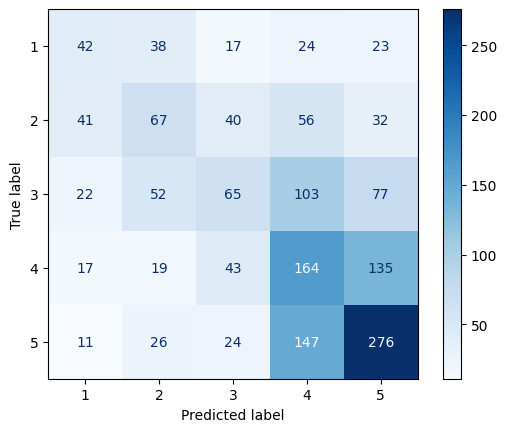

In [37]:
# Se puede visualizar la matriz de confusión
#plot_confusion_matrix(arbol, X_test, Y_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=arbol_final.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.show()

In [38]:
print('Exactitud: %.2f' % accuracy_score(y_testArbol, y_pred))
recall = recall_score(y_testArbol, y_pred, average='weighted')  # Choose an appropriate averaging strategy
print("Recall: {:.2f}".format(recall))
print("Precisión: {}".format(precision_score(y_testArbol,y_pred, average = 'weighted')))
print("Puntuación F1: {}".format(f1_score(y_testArbol,y_pred, average = 'weighted')))

Exactitud: 0.39
Recall: 0.39
Precisión: 0.3875469794417427
Puntuación F1: 0.38426024140926357


##5. Implementación del algoritmo regresión lineal

In [39]:
data_t_corr = data_t.drop(columns=['words' , 'Review'])
correlations = data_t_corr.corr()['Class'].abs().sort_values(ascending=False)
print(correlations)

Class               1.000000
PromedioLongitud    0.266221
Caracteres          0.166820
Palabras Clave      0.151415
Conteo              0.151289
Name: Class, dtype: float64


In [40]:
features = ["words", "Palabras Clave" , "PromedioLongitud"]

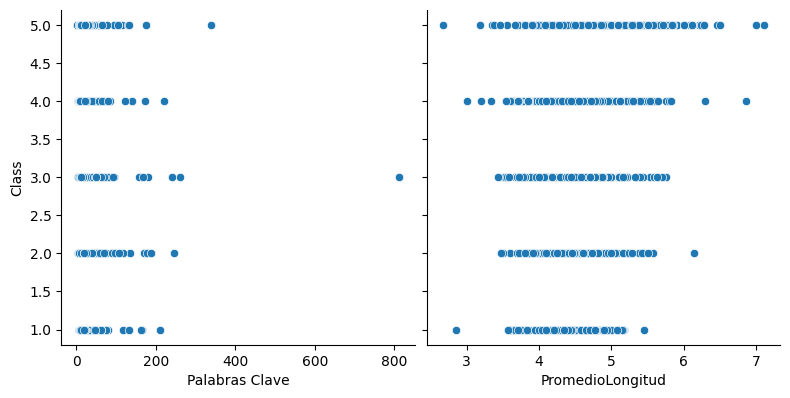

In [41]:
graph = ["Palabras Clave" , "PromedioLongitud"]
sns.pairplot(data_t.sample(frac=0.2), height=4, y_vars="Class", x_vars=graph, kind="scatter")

In [42]:
data_model = data_t
data_model

,Review,Class,words,Palabras Clave,PromedioLongitud,Conteo,Caracteres
0,Nos alojamos en una casa alquilada en la ciuda...,4,yo alog cas ciud amurall parec tant segur cual...,30,4.433333,30,72
1,"La comida está bien, pero nada especial. Yo te...",3,el com bien especial yo mejor com estad unid e...,22,4.272727,22,42
2,"En mi opinión, no es una como muchos usuarios ...",3,en opinion ser gran palad parec ser par grup e...,42,4.619048,42,100
3,esta curiosa forma que asemeja una silla de mo...,4,form sill ahi nombr ciud val pen si pod pod cu...,13,3.692308,13,36
4,Lo mejor era la limonada. Me gusto la comida d...,2,el mejor yo gust com mund fri,7,3.285714,7,20
...,...,...,...,...,...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3,el estanci lug instal bien ser excelent habit ...,45,4.600000,45,115
7871,Es difícil revisar el castillo porque apenas p...,3,ser dificil castill apen pod camin calor cre a...,37,4.621622,37,102
7872,Si vas a Mérida no puedes perderte de este lug...,5,si ir mer pod lug nuev ampli mism calid excele...,14,4.357143,14,31
7873,"Este imperdible sitio, que lleva el nombre del...",5,este imperd siti llev nombr trafic local ambos...,25,4.440000,25,64


In [43]:
Xregresion = data_model[features] # Extracting 'words' column as featur
yregresion = data_model['Class']

In [44]:
# Extracción de características utilizando bolsa de palabras (CountVectorizer)
ngram_range = (1, 2)  # Esto generará unigramas y bigramas
vectorizer = CountVectorizer(ngram_range=ngram_range)
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', vectorizer, "words"),  # Aplica CountVectorizer solo a 'Review'
        ('num', numeric_transformer, ["Palabras Clave" , "PromedioLongitud"])  # Columnas numéricas
    ])
# Aplicar el preprocesador a tus datos
X_preprocessed = preprocessor.fit_transform(Xregresion)
# Separar datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, yregresion, test_size=0.3, random_state=0)

# Entrenamiento del modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# Predicción en el conjunto de prueba
y_pred = model.predict(X_test)

In [45]:
print("Train:", mean_absolute_error(y_train, model.predict(X_train)))
print("Test:", mean_absolute_error(y_test, model.predict(X_test)))

Train: 0.00011870510591472166
Test: 0.8569188760405982


Podemos ver que los resultados para la parte de train son muy buenos, sinembargo en la parte de Test el modelo no se desempeño de una forma correcta ni cercana al entrenamiento. Por esto en la iteración 2 de este algoritmo utilizaremos otro método de regresion que nos permita reducir el sobre ajuste de nuestro modelo a los datos de entrenamiento.

## Iteracion 2 Regresion

In [46]:
features = ["words", "Palabras Clave" , "PromedioLongitud"]

In [47]:
data_model_ridge = data_t
data_model_ridge

,Review,Class,words,Palabras Clave,PromedioLongitud,Conteo,Caracteres
0,Nos alojamos en una casa alquilada en la ciuda...,4,yo alog cas ciud amurall parec tant segur cual...,30,4.433333,30,72
1,"La comida está bien, pero nada especial. Yo te...",3,el com bien especial yo mejor com estad unid e...,22,4.272727,22,42
2,"En mi opinión, no es una como muchos usuarios ...",3,en opinion ser gran palad parec ser par grup e...,42,4.619048,42,100
3,esta curiosa forma que asemeja una silla de mo...,4,form sill ahi nombr ciud val pen si pod pod cu...,13,3.692308,13,36
4,Lo mejor era la limonada. Me gusto la comida d...,2,el mejor yo gust com mund fri,7,3.285714,7,20
...,...,...,...,...,...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3,el estanci lug instal bien ser excelent habit ...,45,4.600000,45,115
7871,Es difícil revisar el castillo porque apenas p...,3,ser dificil castill apen pod camin calor cre a...,37,4.621622,37,102
7872,Si vas a Mérida no puedes perderte de este lug...,5,si ir mer pod lug nuev ampli mism calid excele...,14,4.357143,14,31
7873,"Este imperdible sitio, que lleva el nombre del...",5,este imperd siti llev nombr trafic local ambos...,25,4.440000,25,64


In [48]:
Xridge = data_model_ridge[features]  # Extracting 'words' column as features
yridge = data_model_ridge['Class']

In [49]:
ridge_reg = Ridge()

vectorizerridge =  TfidfVectorizer()
numeric_transformerridge = StandardScaler()
preprocessorridge = ColumnTransformer(
    transformers=[
        ('text', vectorizerridge, "words"),  # Aplica CountVectorizer solo a 'Review'
        ('num', numeric_transformerridge, ["Palabras Clave" , "PromedioLongitud"])  # Columnas numéricas
    ])
X_preprocessedridge = preprocessorridge.fit_transform(Xridge)
X_trainr, X_testr, y_trainr, y_testr = train_test_split(X_preprocessedridge, yridge, test_size=0.4, random_state=0)
# Definir la grilla de hiperparámetros para la búsqueda
param_gridridge = {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 100000.0]}

# Crear el objeto GridSearchCV
grid_searchridge = GridSearchCV(ridge_reg, param_gridridge, cv=5, scoring='neg_mean_absolute_error')  # Especifica el número de folds de validación cruzada

# Ejecutar la búsqueda de hiperparámetros
grid_searchridge.fit(X_trainr, y_trainr)

# Mejor valor de alpha encontrado
best_alpharidge = grid_searchridge.best_params_['alpha']

# Mejor modelo encontrado con el mejor valor de alpha
best_modelridge = grid_searchridge.best_estimator_

# Realizar predicciones en el conjunto de prueba con el mejor modelo
y_pred_ridge = best_modelridge.predict(X_testr)

print("Train:", mean_absolute_error(y_trainr, best_modelridge.predict(X_trainr)))
print("Test:", mean_absolute_error(y_testr, best_modelridge.predict(X_testr)))

Train: 0.6058755056662254
Test: 0.7358486871368235


In [50]:
y_testr.describe(percentiles=[0.25,0.5,0.75,0.99])

count    3122.000000
mean        3.511531
std         1.326544
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
99%         5.000000
max         5.000000
Name: Class, dtype: float64

##6. Implementacion del algoritmo SVM

In [51]:
features = ["words", "Palabras Clave" , "PromedioLongitud"]

In [52]:
data_model_svm = data_t
data_model_svm

,Review,Class,words,Palabras Clave,PromedioLongitud,Conteo,Caracteres
0,Nos alojamos en una casa alquilada en la ciuda...,4,yo alog cas ciud amurall parec tant segur cual...,30,4.433333,30,72
1,"La comida está bien, pero nada especial. Yo te...",3,el com bien especial yo mejor com estad unid e...,22,4.272727,22,42
2,"En mi opinión, no es una como muchos usuarios ...",3,en opinion ser gran palad parec ser par grup e...,42,4.619048,42,100
3,esta curiosa forma que asemeja una silla de mo...,4,form sill ahi nombr ciud val pen si pod pod cu...,13,3.692308,13,36
4,Lo mejor era la limonada. Me gusto la comida d...,2,el mejor yo gust com mund fri,7,3.285714,7,20
...,...,...,...,...,...,...,...
7870,El motivo de mi estancia fue porque vine a un ...,3,el estanci lug instal bien ser excelent habit ...,45,4.600000,45,115
7871,Es difícil revisar el castillo porque apenas p...,3,ser dificil castill apen pod camin calor cre a...,37,4.621622,37,102
7872,Si vas a Mérida no puedes perderte de este lug...,5,si ir mer pod lug nuev ampli mism calid excele...,14,4.357143,14,31
7873,"Este imperdible sitio, que lleva el nombre del...",5,este imperd siti llev nombr trafic local ambos...,25,4.440000,25,64


In [53]:
Xsvm = data_model_svm[features]  # Extracting 'words' column as features
ysvm = data_model_svm['Class']

In [54]:
tf_idf = TfidfVectorizer()

vectorizer =  TfidfVectorizer()
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ('text', vectorizer, "words"),  # Aplica CountVectorizer solo a 'Review'
        ('num', numeric_transformer, ["Palabras Clave" , "PromedioLongitud"])  # Columnas numéricas
    ])
X_preprocessed = preprocessor.fit_transform(Xsvm)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, ysvm, test_size=0.4, random_state=0)
param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'gamma': [0.001, 0.01, 0.1, 1]}

# Crea el clasificador SVM
clf = svm.SVC()

# Crea un objeto GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')

# Realiza la búsqueda de cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)
# Realiza predicciones en el conjunto de prueba con el mejor modelo
y_pred = grid_search.predict(X_test)
# Calcula la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del modelo SVM con mejores parámetros:", accuracy)

Precisión del modelo SVM con mejores parámetros: 0.47789878283151827


In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.48      0.35      0.40       313
           2       0.38      0.37      0.38       461
           3       0.37      0.39      0.38       620
           4       0.42      0.43      0.42       772
           5       0.63      0.67      0.65       956

    accuracy                           0.48      3122
   macro avg       0.46      0.44      0.45      3122
weighted avg       0.48      0.48      0.48      3122



# Etiquetas de los datos

Resultado de los datos etiquetados al elegir la regresión lineal de la iteración 2 como mejor modelo.

In [56]:
X_preprocessedridge = preprocessorridge.fit_transform(Xridge)
y_predfinal = best_modelridge.predict(X_preprocessedridge)
# Crear un DataFrame con las predicciones
df_predicciones = pd.DataFrame({'Predicciones': y_predfinal})
# Reiniciar los índices de ambos DataFrames
df_predicciones['PrediccionesAprox'] = round(df_predicciones['Predicciones'])
df_predicciones.reset_index(drop=True, inplace=True)
data_model_ridge.reset_index(drop=True, inplace=True)
df_combinado = pd.concat([data_model_ridge[['Class', 'Review']], df_predicciones], axis=1)
df_combinado.to_csv('/content/sample_data/EtiquetarDatosEntrenamiento', index=False)
df_combinado

,Class,Review,Predicciones,PrediccionesAprox
0,4,Nos alojamos en una casa alquilada en la ciuda...,4.823092,5.0
1,3,"La comida está bien, pero nada especial. Yo te...",2.938637,3.0
2,3,"En mi opinión, no es una como muchos usuarios ...",3.721813,4.0
3,4,esta curiosa forma que asemeja una silla de mo...,3.914430,4.0
4,2,Lo mejor era la limonada. Me gusto la comida d...,3.136967,3.0
...,...,...,...,...
7799,3,El motivo de mi estancia fue porque vine a un ...,3.660597,4.0
7800,3,Es difícil revisar el castillo porque apenas p...,3.059967,3.0
7801,5,Si vas a Mérida no puedes perderte de este lug...,5.001199,5.0
7802,5,"Este imperdible sitio, que lleva el nombre del...",3.769948,4.0


#Etiqueta de los datos de prueba

In [57]:
datap=pd.read_csv('/content/sample_data/particion_prueba_estudiantes.csv', sep=',', encoding = 'utf-8')
data_p=datap.copy()
data_p = data_p.reset_index(drop = True)
data_p.duplicated(keep = False).sum()
data_p.drop_duplicates(subset=['Review'], inplace=True)
data_p['words'] = data_p['Review'].apply(word_tokenize)
data_p['words'] = data_p['words'].apply(remove_punctuation)
data_p['words'] = data_p['words'].apply(remove_stopwords)
data_p['words'] = data_p['words'].apply(lowerCase)
data_p['words'] = data_p['words'].apply(replace_numbers)
data_p['words'] = data_p['words'].apply(remove_not_valuable_words)
data_p['Palabras Clave'] = data_p['words'].apply(count_words_above_threshold)
data_p['words'] = data_p['words'].apply(lemmatize_words)
data_p['words'] = data_p['words'].apply(stem_words)
data_p['PromedioLongitud'] = data_p['words'].apply(average_word_length)
data_p['Conteo'] = [len(x) for x in data_p['words']]
data_p['Caracteres'] =[len(x.split()) for x in data_p['Review']]
data_p['words'] = data_p['words'].apply(lambda x: ' '.join(map(str, x)))


In [58]:
featuresridge = ["words", "Palabras Clave" , "PromedioLongitud"]
Xfinal1 = data_p[featuresridge]
X_preprocessedridge1 = preprocessorridge.fit_transform(Xfinal1)
y_predfinal2 = best_modelridge.predict(X_preprocessedridge1)
# Crear un DataFrame con las predicciones
df_predicciones = pd.DataFrame({'Predicciones': y_predfinal})
# Reiniciar los índices de ambos DataFrames
df_predicciones['PrediccionesAprox'] = round(df_predicciones['Predicciones'])
df_predicciones.reset_index(drop=True, inplace=True)
data_model_ridge.reset_index(drop=True, inplace=True)
df_combinado = pd.concat([data_p[['Class', 'Review']], df_predicciones], axis=1)
df_combinado.to_csv('/content/sample_data/EtiquetarDatosEntrenamiento', index=False)
df_combinado

ValueError: X has 1370 features, but Ridge is expecting 1481 features as input.

Lastimosamente tenemos este error que no hemos podido resolver para etiquetar los datos de prueba, al parecer tiene al realizar la vectorización de los datos, como son otros datos el modelo pre entrenado esta esperando otro numero de features por lo que no fue posible etiquetar estos datos.